In [1]:
import pandas as pd
import numpy as np
import datetime
from pysus.online_data.SIM import download
from pysus.online_data import cache_contents
from pysus.preprocessing.decoders import decodifica_idade_SIM
from concurrent.futures import ThreadPoolExecutor
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import episem
import matplotlib
%matplotlib inline

In [2]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

# Análise de Excesso de Mortalidade pela COVID-19
Neste notebook iremos comparar a mortalidade resultante da COVID-19 com a média histórica em todos os estados brasileiros.
## Baixando os dados do SIM
Vamos usar a Biblioteca PySUS para baixar os dados de mortalidade por estado

In [7]:
# estados=['SP','RJ','CE','PE','AM']
# tasks = []
# with ThreadPoolExecutor(max_workers=32) as executor:
#     for ano in [2015, 2016, 2017, 2018]:
#         # running once will put these files on disk cache
#         for estado in estados:
#             tasks.append(executor.submit(download, estado, ano))
#     [t.result() for t in tasks]


In [76]:
df = download('SP',2014)
df.columns

Index(['CONTADOR', 'ORIGEM', 'TIPOBITO', 'DTOBITO', 'HORAOBITO', 'NATURAL',
       'CODMUNNATU', 'DTNASC', 'IDADE', 'SEXO', 'RACACOR', 'ESTCIV', 'ESC',
       'ESC2010', 'SERIESCFAL', 'OCUP', 'CODMUNRES', 'LOCOCOR', 'CODESTAB',
       'ESTABDESCR', 'CODMUNOCOR', 'IDADEMAE', 'ESCMAE', 'ESCMAE2010',
       'SERIESCMAE', 'OCUPMAE', 'QTDFILVIVO', 'QTDFILMORT', 'GRAVIDEZ',
       'SEMAGESTAC', 'GESTACAO', 'PARTO', 'OBITOPARTO', 'PESO', 'TPMORTEOCO',
       'OBITOGRAV', 'OBITOPUERP', 'ASSISTMED', 'EXAME', 'CIRURGIA',
       'NECROPSIA', 'LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII',
       'CAUSABAS', 'CB_PRE', 'CRM', 'COMUNSVOIM', 'DTATESTADO', 'CIRCOBITO',
       'ACIDTRAB', 'FONTE', 'NUMEROLOTE', 'TPPOS', 'DTINVESTIG', 'CAUSABAS_O',
       'DTCADASTRO', 'ATESTANTE', 'STCODIFICA', 'CODIFICADO', 'VERSAOSIST',
       'VERSAOSCB', 'FONTEINV', 'DTRECEBIM', 'ATESTADO', 'DTRECORIGA',
       'CAUSAMAT', 'ESCMAEAGR1', 'ESCFALAGR1', 'STDOEPIDEM', 'STDONOVA',
       'DIFDATA', 'NUDIASOBCO', 'NUD

In [5]:
pd.read_parquet?

In [4]:
cols2read = ['NUMERODO', 'CODMUNOCOR','DTOBITO','CAUSABAS', 'IDADE','SEXO','LINHAA', 'LINHAB']
def load_anos(estado='SP'):
    '''
    Lê diretamente do Cache
    '''
    anos = []
    for fi in cache_contents():
        if (f'SIM_DO{estado}' in fi):
            print("Loading ", fi)
            anos.append(pd.read_parquet(fi, engine='pyarrow',columns=cols2read))
#     print(meses)
    ddf = pd.concat(anos)
    return ddf



In [5]:
df_SP = load_anos('SP')
df_SP['idade'] = df.IDADE.apply(lambda x: decodifica_idade_SIM(x))

Loading  /home/fccoelho/pysus/SIM_DOSP2009_.parquet
Loading  /home/fccoelho/pysus/SIM_DOSP2015_.parquet
Loading  /home/fccoelho/pysus/SIM_DOSP2010_.parquet
Loading  /home/fccoelho/pysus/SIM_DOSP2018_.parquet
Loading  /home/fccoelho/pysus/SIM_DOSP2012_.parquet
Loading  /home/fccoelho/pysus/SIM_DOSP2013_.parquet
Loading  /home/fccoelho/pysus/SIM_DOSP2016_.parquet
Loading  /home/fccoelho/pysus/SIM_DOSP2011_.parquet
Loading  /home/fccoelho/pysus/SIM_DOSP2014_.parquet
Loading  /home/fccoelho/pysus/SIM_DOSP2017_.parquet


NameError: name 'df' is not defined

In [6]:
def converte_datas(df):
    for c in df.columns:
        if c.startswith('DT'):
            df[c] = pd.to_datetime(df[c],format='%d%m%Y', errors='coerce')
    return df
df_SP = converte_datas(df_SP)
df_SP.set_index('DTOBITO',inplace=True)

In [7]:
df_SP.to_csv('../csv/SIM_SP_2009-2019.csv')
df_SP

,CODMUNOCOR,CAUSABAS,IDADE,SEXO,LINHAA,LINHAB
DTOBITO,,,,,,
2009-04-02,410395,W708,448,1,*R090,*W708
2009-01-14,521180,V499,447,1,*S069,*T07X
2009-01-03,355720,V093,999,1,*V093*T07X,
2009-01-19,355240,J189,999,1,*R092,*J189
2009-03-15,355040,Y349,449,1,*Y349,
...,...,...,...,...,...,...
2017-04-13,353760,R960,465,1,*R96X,
2017-04-19,353760,R99,455,1,*R99X,
2017-01-10,354995,J189,487,1,*R092,*I509


In [8]:
pneu = ['J09','J090','J100','J108','J110','J111','J118','J120','J121','J122','J128','J129','J171']
# pneu = set([cid for cid in df_SP.CAUSABAS if cid.startswith('J1')])
pneu_SP = df_SP[df_SP.CAUSABAS.isin(pneu)|df_SP.LINHAA.isin(pneu)|df_SP.LINHAB.isin(pneu)]

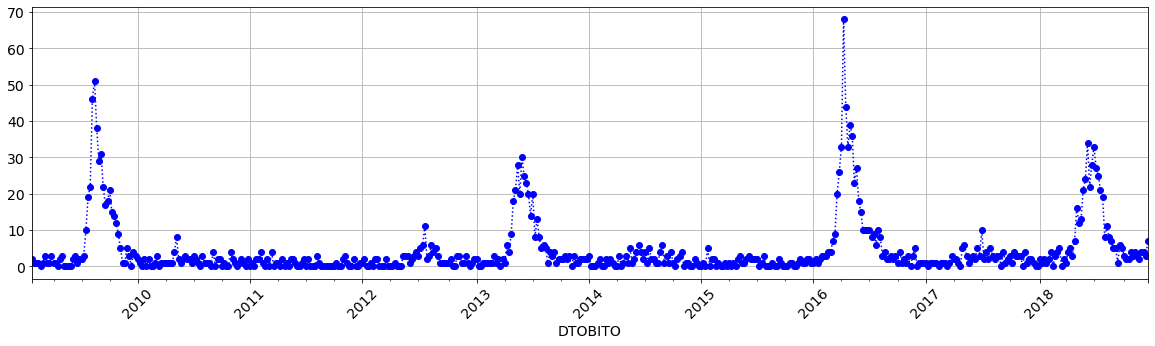

In [9]:
ax = pneu_SP.CAUSABAS.resample('W').count().plot(style='b:o',rot=45, figsize=(20,5), grid=True, label='Baseline');

## Baixando os dados de mortalidade por COVID19

In [10]:
# Fetching cases from Brasil.io
nodes = pd.read_csv('../csv/nodesUF.csv.gz')
cases = pd.read_csv('https://brasil.io/dataset/covid19/caso?format=csv')
nodes = pd.merge(nodes,cases[(cases.is_last)], left_on='tgt', right_on='city_ibge_code', how='left')
nodes = nodes[['tgt','tgtname','tgt_UFCOD','tgtpop','confirmed']]
cases

,date,state,city,place_type,confirmed,deaths,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2020-04-26,AC,Acrelândia,city,12,0,True,15256.0,1200013.0,78.65758,NaN
1,2020-04-26,AC,Bujari,city,1,0,True,10266.0,1200138.0,9.74089,NaN
2,2020-04-26,AC,Cruzeiro do Sul,city,5,0,True,88376.0,1200203.0,5.65764,NaN
3,2020-04-26,AC,Plácido de Castro,city,22,1,True,19761.0,1200385.0,111.33040,0.0455
4,2020-04-26,AC,Porto Acre,city,2,0,True,18504.0,1200807.0,10.80847,NaN
...,...,...,...,...,...,...,...,...,...,...,...
32869,2020-02-27,SP,NaN,state,1,0,False,45919049.0,35.0,0.00218,NaN
32870,2020-02-26,SP,São Paulo,city,1,0,False,12252023.0,3550308.0,0.00816,NaN
32871,2020-02-26,SP,NaN,state,1,0,False,45919049.0,35.0,0.00218,NaN
32872,2020-02-25,SP,São Paulo,city,1,0,False,12252023.0,3550308.0,0.00816,NaN


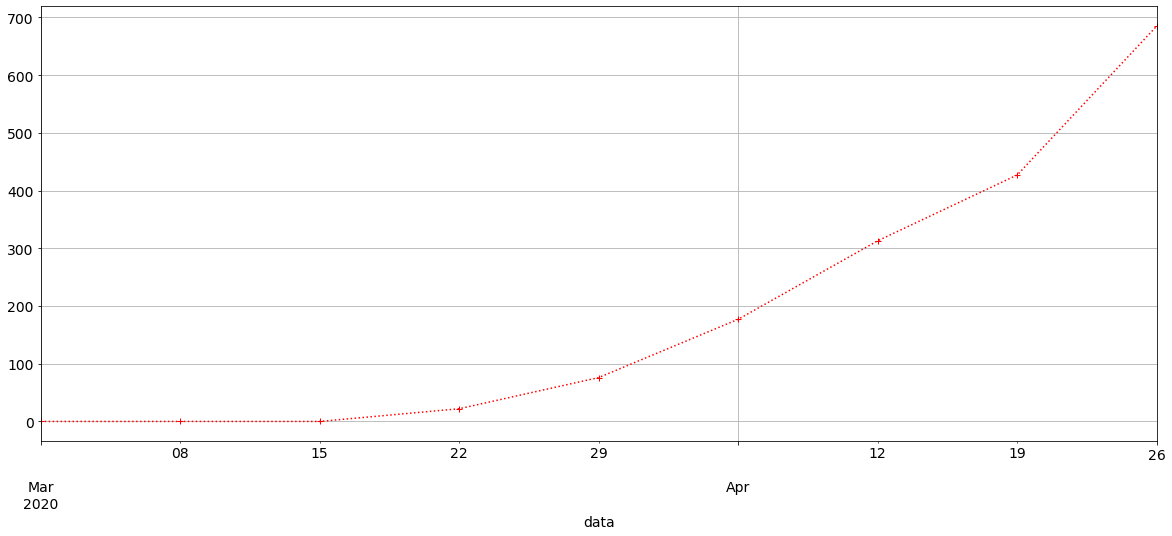

In [11]:
obitos_SP = cases[(cases.state=='SP')&(cases.place_type=='state')][['date','confirmed','deaths']]
obitos_SP['data'] = pd.to_datetime(obitos_SP.date)
obitos_SP.set_index('data', inplace=True)
obitos_SP.sort_index(inplace=True)
obitos_SP['incidencia'] = obitos_SP.deaths.diff()
obitos_SP['ew'] = [int(episem.episem(x,out='W')) for x in obitos_SP.index]
obitos_SP.incidencia.resample('W').sum().plot(style='r:+',figsize=(20,8), grid=True);

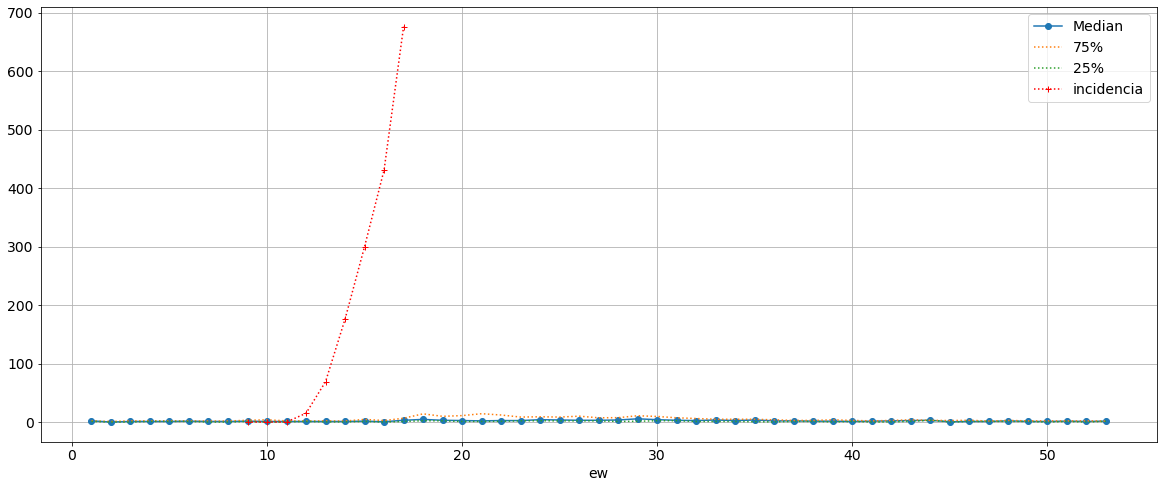

In [12]:
avg = pneu_SP.resample('W').count()
avg['week'] = avg.index.week
ax = avg.groupby('week').median().CAUSABAS.plot(style='-o',figsize=(20,5), grid=True, label='Median')
avg.groupby('week').agg(lambda x: np.percentile(x,75)).CAUSABAS.plot(ax=ax,style=':',figsize=(20,5), grid=True, label='75%')
avg.groupby('week').agg(lambda x: np.percentile(x,25)).CAUSABAS.plot(ax=ax,style=':',figsize=(20,5), grid=True, label='25%')
obitos_SP.groupby('ew').sum().incidencia.iloc[:-1].plot(ax=ax, style='r:+',figsize=(20,8), grid=True, logy=False);
ax.legend();

In [65]:
obitos_SP.groupby('ew').sum().incidencia.values
from plotly.validators.scatter.marker import SymbolValidator
raw_symbols = SymbolValidator().values
raw_symbols

[0,
 'circle',
 100,
 'circle-open',
 200,
 'circle-dot',
 300,
 'circle-open-dot',
 1,
 'square',
 101,
 'square-open',
 201,
 'square-dot',
 301,
 'square-open-dot',
 2,
 'diamond',
 102,
 'diamond-open',
 202,
 'diamond-dot',
 302,
 'diamond-open-dot',
 3,
 'cross',
 103,
 'cross-open',
 203,
 'cross-dot',
 303,
 'cross-open-dot',
 4,
 'x',
 104,
 'x-open',
 204,
 'x-dot',
 304,
 'x-open-dot',
 5,
 'triangle-up',
 105,
 'triangle-up-open',
 205,
 'triangle-up-dot',
 305,
 'triangle-up-open-dot',
 6,
 'triangle-down',
 106,
 'triangle-down-open',
 206,
 'triangle-down-dot',
 306,
 'triangle-down-open-dot',
 7,
 'triangle-left',
 107,
 'triangle-left-open',
 207,
 'triangle-left-dot',
 307,
 'triangle-left-open-dot',
 8,
 'triangle-right',
 108,
 'triangle-right-open',
 208,
 'triangle-right-dot',
 308,
 'triangle-right-open-dot',
 9,
 'triangle-ne',
 109,
 'triangle-ne-open',
 209,
 'triangle-ne-dot',
 309,
 'triangle-ne-open-dot',
 10,
 'triangle-se',
 110,
 'triangle-se-open',
 210

In [54]:
baseline = pd.DataFrame(data = {
                        'p75': avg.groupby('week').agg(lambda x: np.percentile(x,75)).CAUSABAS.values,
                        'median': avg.groupby('week').median().CAUSABAS.values,
                        'p25': avg.groupby('week').agg(lambda x: np.percentile(x,25)).CAUSABAS.values
                        }, index = range(1,54))
baseline.index.name = 'ew'
baseline.to_csv('obitosSP_baseline.csv.gz')
baseline

,p75,median,p25
ew,,,
1,2.00,2.0,1.00
2,1.00,0.0,0.00
3,2.00,1.0,0.00
4,2.00,1.0,1.00
5,2.00,1.0,1.00
6,2.00,1.5,1.00
7,1.75,1.0,0.00
8,1.75,1.0,0.00
9,3.00,1.5,1.00


In [47]:
avg.groupby('week').median().CAUSABAS

week
1     2.0
2     0.0
3     1.0
4     1.0
5     1.0
6     1.5
7     1.0
8     1.0
9     1.5
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.5
16    0.5
17    3.0
18    4.5
19    3.0
20    2.5
21    2.0
22    2.5
23    2.5
24    4.0
25    3.5
26    3.0
27    3.0
28    3.5
29    5.5
30    4.0
31    3.0
32    2.5
33    3.5
34    2.5
35    3.5
36    2.0
37    2.0
38    1.5
39    1.5
40    1.0
41    1.5
42    2.0
43    2.5
44    3.0
45    0.5
46    1.0
47    1.0
48    2.0
49    1.0
50    1.0
51    1.5
52    1.0
53    1.5
Name: CAUSABAS, dtype: float64

In [49]:
obitos_SP.incidencia.resample('W').sum()

data
2020-03-01      0.0
2020-03-08      0.0
2020-03-15      0.0
2020-03-22     22.0
2020-03-29     76.0
2020-04-05    177.0
2020-04-12    313.0
2020-04-19    427.0
2020-04-26     78.0
Freq: W-SUN, Name: incidencia, dtype: float64

In [122]:
len(obitos_SP)

56

## Baixando dados de mortalidade dos cartórios

In [13]:
BRASIL_IO_CART = "https://brasil.io/dataset/covid19/obito_cartorio?format=csv"
def get_data_from_cart(source, usecols=None, rename_cols=None):
    df = pd.read_csv(source, usecols=usecols)
    if rename_cols:
        df.rename(columns=rename_cols)
    df["date"] = pd.to_datetime(df["date"])
    return df

def get_data_cart_uf(data, uf, variable):
    if uf:
        data = data.loc[data.state.isin(uf)]
        region_name = "Estado"
        data = data.loc[:, ["date", "state", variable]]
        pivot_data = data.pivot_table(values=variable, index="date", columns="state")
        data = pd.DataFrame(pivot_data.to_records())
    else:
        region_name = "Brasil"
        data = data.groupby("date")[variable].sum().to_frame().reset_index()

    melted_data = pd.melt(
        data,
        id_vars=['date'],
        var_name=region_name,
        value_name=variable,
    )
    return region_name, melted_data

full_cdf = get_data_from_cart(BRASIL_IO_CART)
cart_covid_SP = get_data_cart_uf(full_cdf,['SP'],'deaths_covid19' )
cart_covid_SP

('Estado',
           date Estado  deaths_covid19
 0   2020-01-01     SP               0
 1   2020-01-02     SP               0
 2   2020-01-03     SP               0
 3   2020-01-04     SP               0
 4   2020-01-05     SP               0
 ..         ...    ...             ...
 113 2020-04-23     SP            2044
 114 2020-04-24     SP            2053
 115 2020-04-25     SP            2055
 116 2020-04-26     SP            2055
 117 2020-04-27     SP            2056
 
 [118 rows x 3 columns])

In [14]:
full_cdf.to_csv(f'../csv/obitos_cartorio{datetime.date.today()}.csv')
full_cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3186 entries, 0 to 3185
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 3186 non-null   datetime64[ns]
 1   state                                3186 non-null   object        
 2   deaths_pneumonia_2019                3186 non-null   int64         
 3   deaths_pneumonia_2020                3186 non-null   int64         
 4   deaths_covid19                       3186 non-null   int64         
 5   deaths_respiratory_failure_2019      3186 non-null   int64         
 6   deaths_respiratory_failure_2020      3186 non-null   int64         
 7   epidemiological_week_2020            3186 non-null   int64         
 8   new_deaths_pneumonia_2020            3186 non-null   int64         
 9   new_deaths_covid19                   3186 non-null   int64         
 10  new_deaths_r

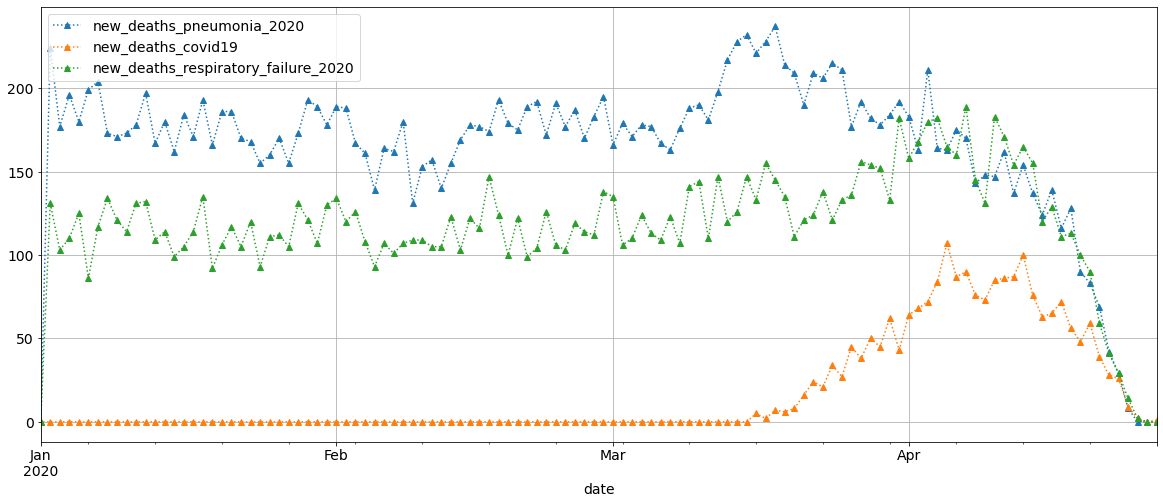

In [16]:
curves = [col for col in full_cdf.columns if col.startswith('new') and col != 'date']
full_cdf[full_cdf.state=='SP'].set_index('date')[curves].plot(style=':^',stacked=False,figsize=(20,8), grid=True);

In [119]:
full_cdf[full_cdf.state=='SP'].head(50)

,date,state,deaths_pneumonia_2019,deaths_pneumonia_2020,deaths_covid19,deaths_respiratory_failure_2019,deaths_respiratory_failure_2020,epidemiological_week_2020,new_deaths_pneumonia_2020,new_deaths_covid19,new_deaths_respiratory_failure_2020
25,2020-04-23,SP,20391,18841,1669,13542,13264,17,0,0,0
52,2020-04-22,SP,20206,18841,1669,13410,13264,17,2,0,5
79,2020-04-21,SP,20028,18839,1669,13289,13259,17,9,4,7
106,2020-04-20,SP,19840,18830,1665,13161,13252,17,12,7,19
133,2020-04-19,SP,19661,18818,1658,13043,13233,17,23,16,26
160,2020-04-18,SP,19482,18795,1642,12918,13207,16,41,17,38
187,2020-04-17,SP,19297,18754,1625,12793,13169,16,43,18,38
214,2020-04-16,SP,19109,18711,1607,12680,13131,16,77,36,68
241,2020-04-15,SP,18907,18634,1571,12560,13063,16,89,40,76
268,2020-04-14,SP,18733,18545,1531,12429,12987,16,99,61,127
